# Informetis Assessment Q4

You are given a dataset that contains occurences of the Kettle in a single-occupancy house for the duration of a month. In this dataset, ‘ts’ column indicates the unix-timestamp (this can be converted to date and time) that the kettle was turned ON; and the ‘second’ column indicates the duration in seconds that the kettle was ON.

Task 1: Find routines in the data, evaluate their periodicities and variabilities. For instance, a routine could be “breakfast”, its periodicity might be every day at a certain time and variability might be a time window within the routine occurred. 

Task 2: Detect anomalies whenever there is a deviation from the routines.

Please provide a script which attempts task 1 and 2. Please do not provide a script without explanations

# Task 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt

In [2]:
q4 = pd.read_csv('Q4-data.csv', infer_datetime_format=True)

In [3]:
q4['dt'] = q4['ts'].apply(dt.datetime.utcfromtimestamp)

In [4]:
q4['date'] = q4['dt'].dt.date
q4['time'] = q4['dt'].dt.time
q4['day'] = q4['dt'].dt.day
q4['hour'] = q4['dt'].dt.hour
q4['minute'] = q4['dt'].dt.minute
q4['weekday'] = q4['dt'].dt.weekday
q4['second'] = q4['dt'].dt.second

In [5]:
q4['weekend'] = q4['weekday'].isin([0,6])
q4['minute_of_day'] = q4['dt'].apply(lambda d: d.hour*60 + d.minute)
q4['hour_float'] = q4['minute_of_day']/60
q4['half_hour'] = q4['minute_of_day']//30
q4['quarter_hour'] = q4['minute_of_day']//15

In [6]:
q4['sin_time'] = np.sin(2*np.pi*q4['hour_float']/24)
q4['cos_time'] = np.cos(2*np.pi*q4['hour_float']/24)

## Exploratory Analysis

Below is a scatter plot of raw datapoints, indicating the time at which kettle was switched on for each day of the month. The X-axis indicate the time of the day, Y-axis indicate the day of the month, and the size of the scatter points indicate the time for which the kettle was on in seconds (not to be scaled). 

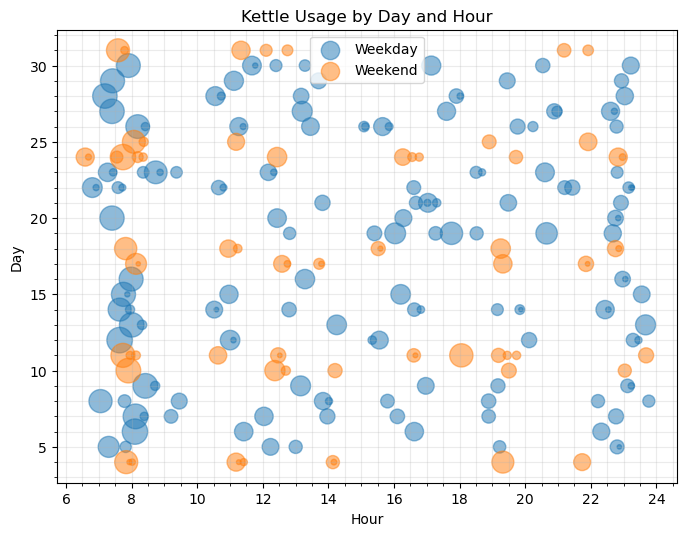

In [7]:
plt.figure(figsize=(8,6), dpi=100)
for weekend in [False, True]:
    df = q4[q4['weekend']==weekend]
    plt.scatter(df['hour_float'], df['day'], s=df['seconds'], alpha=0.5)
plt.xticks(range(6, 25, 2))
plt.xlabel('Hour'); plt.ylabel('Day')
plt.minorticks_on()
plt.grid(which='both',alpha=0.25)
plt.legend(['Weekday', 'Weekend'])
plt.title('Kettle Usage by Day and Hour')
plt.show()

### Analysing Data in Half Hourly Window

In [8]:
q4['half_hour'].value_counts().head(10).index/2

Float64Index([7.5, 22.5, 8.0, 11.0, 23.0, 16.5, 12.0, 19.0, 10.5, 7.0], dtype='float64')

In [9]:
q4['half_hour'].value_counts().head(10)

15    21
45    18
16    17
22    12
46    11
33    10
24    10
38    10
21     9
14     8
Name: half_hour, dtype: int64

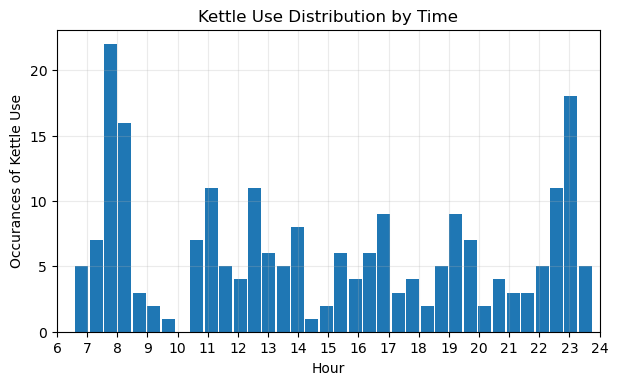

In [10]:
plt.figure(figsize=(7,4), dpi=100)
plt.hist(q4['hour_float'], bins=36, rwidth=0.9)
plt.xlim(6,24)
plt.xticks(range(6,25))
plt.grid(alpha=0.25)
plt.xlabel('Hour')
plt.ylabel('Occurances of Kettle Use')
plt.title('Kettle Use Distribution by Time')
plt.show()

### Based on visual Inspection of Aggregated Data

**For half-hourly windows of time, 5 peaks were identified:**
+ 7:45 AM with a variability of 3 hours
+ 11:00 PM with a variability of 2 hours
+ 01:00 PM with a variability of 2.5 hours
+ 11:00 AM with a variability of 2.5 hours
+ 04:30 PM with a variability of 2 hours
+ 07:00 PM with a variability fo 2 hour

## Transforming Data

### Grouping data by `half_hour` 

In [11]:
q4['instance'] = 1

In [12]:
q4.columns

Index(['Unnamed: 0', 'ts', 'seconds', 'dt', 'date', 'time', 'day', 'hour',
       'minute', 'weekday', 'second', 'weekend', 'minute_of_day', 'hour_float',
       'half_hour', 'quarter_hour', 'sin_time', 'cos_time', 'instance'],
      dtype='object')

In [13]:
q4.drop(columns=['Unnamed: 0'], inplace=True)

In [14]:
q4.head()

,ts,seconds,dt,date,time,day,hour,minute,weekday,second,weekend,minute_of_day,hour_float,half_hour,quarter_hour,sin_time,cos_time,instance
0,1551685815,275,2019-03-04 07:50:15,2019-03-04,07:50:15,4,7,50,0,15,True,470,7.833333,15,31,0.887011,-0.461749,1
1,1551686207,14,2019-03-04 07:56:47,2019-03-04,07:56:47,4,7,56,0,47,True,476,7.933333,15,31,0.874620,-0.484810,1
2,1551686461,21,2019-03-04 08:01:01,2019-03-04,08:01:01,4,8,1,0,1,True,481,8.016667,16,32,0.863836,-0.503774,1
3,1551697913,170,2019-03-04 11:11:53,2019-03-04,11:11:53,4,11,11,0,53,True,671,11.183333,22,44,0.212178,-0.977231,1
4,1551698199,12,2019-03-04 11:16:39,2019-03-04,11:16:39,4,11,16,0,39,True,676,11.266667,22,45,0.190809,-0.981627,1


In [15]:
grouped_half_hour = q4[['half_hour','instance']].groupby('half_hour', as_index=False).sum()
grouped_half_hour['hour_float'] = grouped_half_hour['half_hour']/2

In [16]:
grouped_half_hour.head()

,half_hour,instance,hour_float
0,13,4,6.5
1,14,8,7.0
2,15,21,7.5
3,16,17,8.0
4,17,3,8.5


### Dividing the peaks

In [17]:
kettle_instances = grouped_half_hour.instance.ravel()

In [18]:
kettle_instances

array([ 4,  8, 21, 17,  3,  3,  9, 12,  2, 10,  7,  7,  6,  5,  4,  6,  5,
       10,  5,  3,  2,  6, 10,  6,  2,  5,  3,  5,  3, 18, 11,  4],
      dtype=int64)

In [19]:
split_index = []

for i, instance in enumerate(kettle_instances):
    try:
        if instance <= kettle_instances[i-1] and instance<=kettle_instances[i+1] and i>0:
            split_index.append(i)
    except:
        pass

split_index.insert(0, 0)
split_index.append(len(kettle_instances)-1)

In [20]:
split_index

[0, 4, 5, 8, 10, 14, 16, 20, 24, 26, 28, 31]

Text(0.5, 1.0, 'Kettle Usage Division by Peak Times')

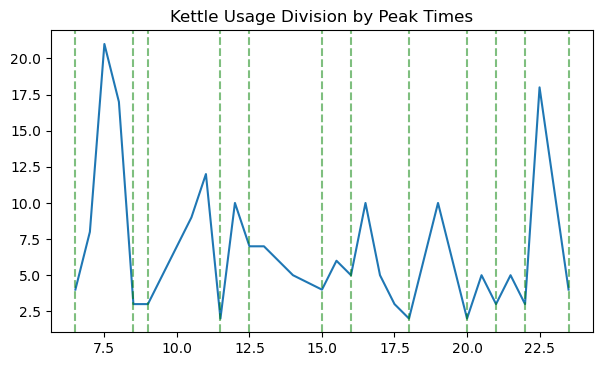

In [21]:
plt.figure(figsize=(7,4), dpi=100)
plt.plot(grouped_half_hour['hour_float'], grouped_half_hour['instance'])
for i in split_index: 
    plt.axvline(grouped_half_hour['hour_float'][i], alpha=0.5, c='g', linestyle='--')
plt.title('Kettle Usage Division by Peak Times')

**Grouping Splits Nearby Peaks Together**

In [22]:
for i in [4, 10, 16, 24,28]:
    split_index.remove(i)

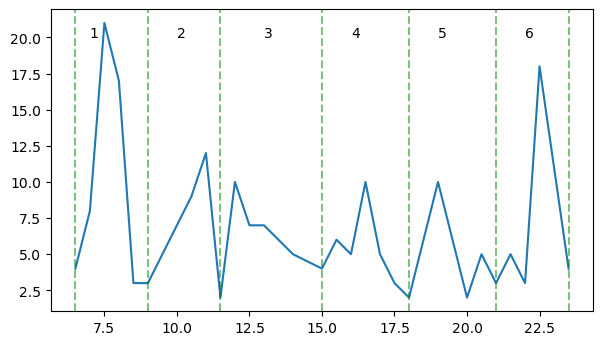

In [23]:
plt.figure(figsize=(7,4), dpi=100)
plt.plot(grouped_half_hour['hour_float'], grouped_half_hour['instance'])
for i in split_index: 
    plt.axvline(grouped_half_hour['hour_float'][i], alpha=0.5, c='g', linestyle='--')
for time, label in zip([7, 10, 13, 16, 19, 22],[1, 2, 3, 4, 5, 6]):
    plt.text(time, 20, label)
plt.show()

In [24]:
time_boundaries_hour_float = grouped_half_hour.loc[split_index]['hour_float'].ravel()

**The times at which these splits correspond to**

In [25]:
time_boundaries_hour_float

array([ 6.5,  9. , 11.5, 15. , 18. , 21. , 23.5])

## Splitting the Raw Data by These Groups

Here we're splitting the Raw data by these 6 groups, and also extracting the quantiles of each of the groups to undertand the distribution and variability in the data.

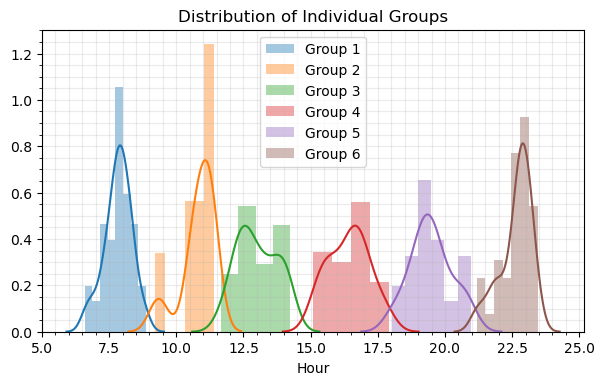

In [26]:
split_dfs = {}
quantile_boundaries = {}

plt.figure(figsize=(7,4), dpi=100)

for i in range(1, len(time_boundaries_hour_float)):
    group_df = q4[(q4['hour_float']>=time_boundaries_hour_float[i-1]) & (q4['hour_float']<=time_boundaries_hour_float[i])].copy()
    q_1 = np.quantile(group_df['hour_float'], 0.25)
    q_2 = np.quantile(group_df['hour_float'], 0.5)
    q_3 = np.quantile(group_df['hour_float'], 0.75)
    iqr = q_3 - q_1
    min_boundary = q_1 - 1.5*iqr
    max_boundary = q_3 + 1.5*iqr
    quantile_boundaries[i] = [min_boundary, q_1, q_2, q_3, max_boundary]
    group_df['Outliers'] = (group_df['hour_float']<min_boundary) | (group_df['hour_float']>max_boundary)
    split_dfs[i] = group_df.copy() 
    sns.distplot(group_df['hour_float'], label='Group {}'.format(i))
plt.legend()
plt.minorticks_on()
plt.grid(which='both', alpha=0.25)
plt.xlabel('Hour')
plt.title('Distribution of Individual Groups')
plt.show()

Please note that the above data is normalised be individual group levels, and is not comparative. It's just plotted on the sample axis for easier visualisation.

## Here are the 6 Peak Times the Kettle is Used

The peak is determined by the median of each groups we split in the earlier section, and the variability is determined by the boundaries of the quantile distribution of the respective group. The code below can be adjusted to use `hours=value[1]` to `hours=value[3]` in order to use Q1 and Q3 as the variability limits. The same sort of analysis can also be done in terms of standard deviation as an alternative method.

In [27]:
print('Here are the 6 Peak Times at which kettle is used:\n')
for key, value in quantile_boundaries.items():
    print('Peak {} occurs at {}'.format(key, str(dt.timedelta(hours=value[2]))))
    print('Variability for Peak {}: from {} to {}\n'.format(key, str(dt.timedelta(hours=value[0])), str(dt.timedelta(hours=value[-1]))))

Here are the 6 Peak Times at which kettle is used:

Peak 1 occurs at 7:52:00
Variability for Peak 1: from 6:45:30 to 8:57:30

Peak 2 occurs at 10:59:00
Variability for Peak 2: from 9:41:22.500000 to 12:10:22.500000

Peak 3 occurs at 12:49:00
Variability for Peak 3: from 10:30:30 to 15:38:30

Peak 4 occurs at 16:36:00
Variability for Peak 4: from 14:03:00 to 18:43:00

Peak 5 occurs at 19:27:00
Variability for Peak 5: from 17:47:15 to 21:05:15

Peak 6 occurs at 22:48:00
Variability for Peak 6: from 21:27:37.500000 to 23:58:37.500000



# Task 2

## Outlier Detection using Quantiles

The outliers are determined by the quantial ranges extracted in the previous section.

In [28]:
final_df = pd.concat([df for df in split_dfs.values()])

In [29]:
final_df.drop_duplicates(subset=['ts'], inplace=True)

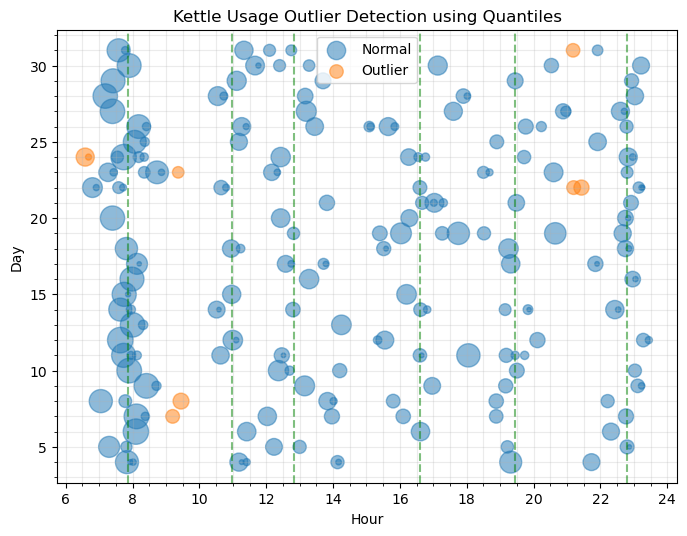

In [30]:
plt.figure(figsize=(8,6), dpi=100)
for is_outlier in [False, True]:
    df = final_df[final_df['Outliers']==is_outlier]
    plt.scatter(df['hour_float'], df['day'], s=df['seconds'], alpha=0.5)
plt.xticks(range(6, 25, 2))
plt.xlabel('Hour'); plt.ylabel('Day')
plt.minorticks_on()
plt.grid(which='both',alpha=0.25)
plt.legend(['Normal', 'Outlier'])
plt.title('Kettle Usage Outlier Detection using Quantiles')
for group in quantile_boundaries.values():
    plt.axvline(group[2], c='g', ls='--', alpha=0.5)
plt.show()

## Outlier Detection Using Local Outlier Factor 

Local Outlier Factor is a simple approach to identifying outliers is to locate those instances that are far from the other instances in the feature space. Here we're only using time and weekday features. Note that the time has been transformed to sin and cos, which will capture the cylic nature of the dimension.

In [31]:
from sklearn.neighbors import LocalOutlierFactor

In [32]:
features = [
    'sin_time',
    'cos_time',
    'weekday',
    'weekend'
]

In [33]:
lof = LocalOutlierFactor(7)

In [34]:
X_lof = lof.fit_predict(q4[features])

In [35]:
mask = X_lof != -1

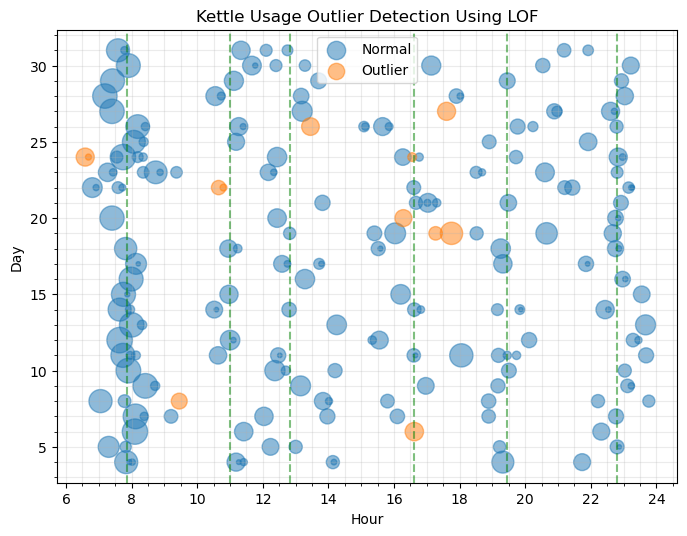

In [36]:
plt.figure(figsize=(8,6), dpi=100)
for is_outlier in [True, False]:
    df = q4[mask==is_outlier]
    plt.scatter(df['hour_float'], df['day'], s=df['seconds'], alpha=0.5)
plt.xticks(range(6, 25, 2))
plt.xlabel('Hour'); plt.ylabel('Day')
plt.minorticks_on()
plt.grid(which='both',alpha=0.25)
plt.legend(['Normal', 'Outlier'])
plt.title('Kettle Usage Outlier Detection Using LOF')
for group in quantile_boundaries.values():
    plt.axvline(group[2], c='g', ls='--', alpha=0.5)
plt.show()

# Discussion and Recommendations

+ For the variability and outlier detection analysis could also be carried out using mean and standard deviations
+ Isolation Forests is also a good choice for outlier detection, which uses differences in tree-depth as a measure of complexity to identify the outliers/anomalies, ones for which the algorithm creates a much shorter path in the decision trees
+ Larger set of data would help identify these periodicities and variabilities in a more robust manner and create reliable results